# Testing Metacalibration

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
##Local settings
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
sys.path.append("..")
import autometacal

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
from scipy.stats import linregress

## Get Data

In [5]:
data = tfds.load('gal_gen/small_stamp_100',as_supervised=False,with_info=False)
data = data['train'].take(100)
datait = data.as_numpy_iterator()
datalist=[next(datait) for i in range(100)]
example = datalist[0]

Re-complexify 2xNxN real arrays to NxN complex arrays

In [6]:
obs_kimage = autometacal.datasets.gal_gen.recomplexify(example['obs_kimage'])
psf_kimage = autometacal.datasets.gal_gen.recomplexify(example['psf_kimage'])
psf_deconv = autometacal.datasets.gal_gen.recomplexify(example['psf_deconv'])
imnos = autometacal.datasets.galaxies.gs_noise_generator(variance=10)*0
metacal_img_test=autometacal.metacal.generate_mcal_image(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,  [0.05,0.05])

See what we got to work with:

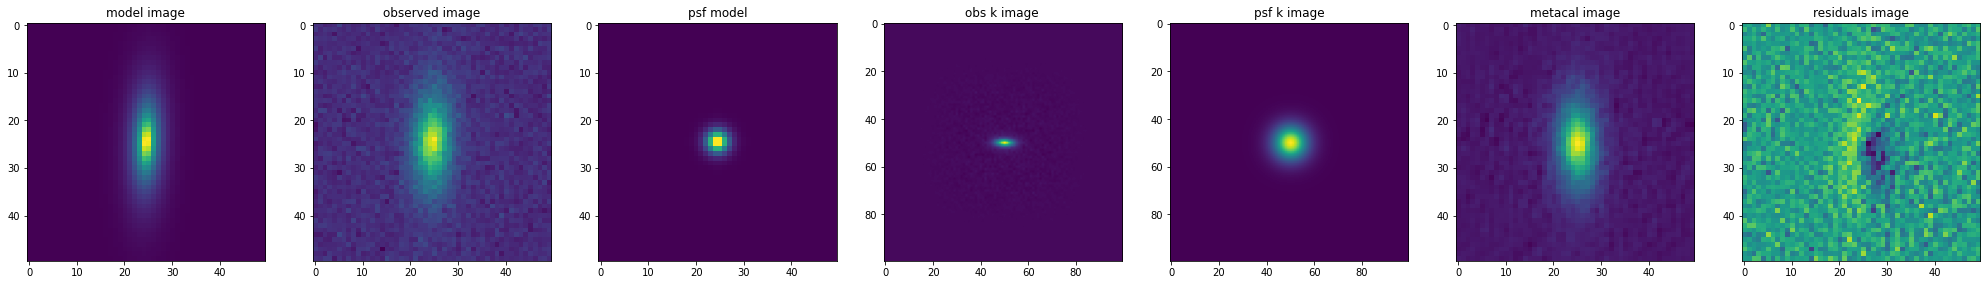

In [7]:
figure(figsize=[35,5])

subplot(171)
title('model image')
imshow(example['gal_model'])

subplot(172)
title('observed image')
imshow(example['obs_image'])

subplot(173)
title('psf model')
imshow(example['psf_image'])

subplot(174)
title('obs k image ')
imshow(obs_kimage.real)

subplot(175)
title('psf k image')
imshow(psf_kimage.real)

subplot(176)
title('metacal image')
imshow(metacal_img_test[0,...,0])

subplot(177)
title('residuals image')
imshow(example['obs_image'] - metacal_img_test[0,...,0] )
plt.savefig('first_function_test.jpeg',bbox_inches='tight')

## Ellipticity Measurements

Simple test:

In [10]:
g_result, R =autometacal.metacal.get_metacal_response(example['obs_image'],
                    example['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    imnos,get_ellipticity)

In [11]:
# Apply inverse response matrix :-D
calibrated_g = tf.linalg.inv(R) @ tf.reshape(g_result,[2,1])

In [12]:
print("measured ellipticity  ", get_ellipticity(metacal_img_test[0,...,0]))
print("calibrated ellipticity", calibrated_g.numpy().squeeze())
print("true g1,g2            ",example['label'])

measured ellipticity   (<tf.Tensor: shape=(), dtype=float32, numpy=-0.26382908>, <tf.Tensor: shape=(), dtype=float32, numpy=0.011095124>)
calibrated ellipticity [-0.6874573  -0.02002545]
true g1,g2             [-0.52710474 -0.0362318 ]


## Measuring ellipticities on a set of galaxies

In [13]:
g_result_list = []
R_list = []
for datapoint in datalist:
  obs_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['obs_kimage'])
  psf_kimage = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_kimage'])
  psf_deconv = autometacal.datasets.gal_gen.recomplexify(datapoint['psf_deconv'])
  
  k_noise = autometacal.datasets.galaxies.gs_noise_generator(stamp_size=50,variance=5)
  g_result, R =autometacal.metacal.get_metacal_response(datapoint['obs_image'],
                    datapoint['psf_image'],
                    obs_kimage, 
                    psf_kimage,
                    psf_deconv,
                    k_noise,get_ellipticity)
  
  
  
  g_result_list.append(g_result)
  R_list.append(R)
  

Mean responsivity:

In [14]:
R_mean=np.nanmean(np.array(R_list),axis=0)
g_results_calib_mean = [ tf.linalg.inv(np.nanmean(np.array(R_list),axis=0)) @ tf.reshape(g_result,[2,1]) for g_result in g_result_list ]

## Plots

Get $g_1$ and $g_2$ for plots

In [15]:
g1_labels = np.array([datapoint['label'][0] for datapoint in datalist])
g1_results = np.array([g_result[0] for g_result in g_result_list ])
g1_calib_mean =np.array(g_results_calib_mean)[:,0]

In [16]:
g2_labels = np.array([datapoint['label'][1] for datapoint in datalist])
g2_results = np.array([g_result[1] for g_result in g_result_list ])
g2_calib_mean =np.array(g_results_calib_mean)[:,1]

Plot residuals with biases:

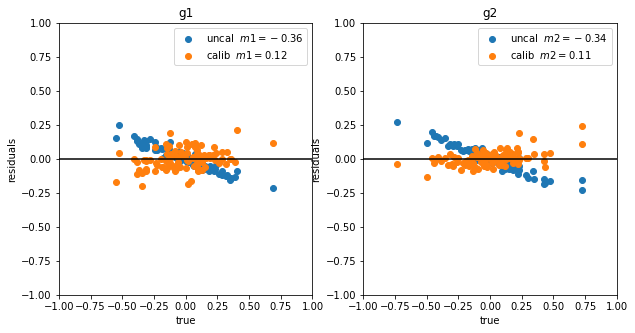

In [18]:
figure(figsize=(10,5))

y1_uncal = g1_results-g1_labels
y1_avcal = g1_calib_mean.reshape([-1])-g1_labels
m1_uncal, c1_uncal = linregress(g1_labels, y1_uncal)[:2] 
m1_avcal, c1_avcal = linregress(g1_labels, y1_avcal)[:2]

subplot(121)

scatter(g1_labels, y1_uncal, label=f'uncal  $m1 = {m1_uncal :.2f}$')
scatter(g1_labels, y1_avcal, label=f'calib  $m1 = {m1_avcal :.2f}$')

plot([-1,1],[0,0],color='black')
xlim([-1,1])
ylim([-1,1])
legend()
xlabel('true')
ylabel('residuals')
title('g1')

y2_uncal = g2_results-g2_labels

y2_avcal = g2_calib_mean.reshape([-1])-g2_labels
m2_uncal, c2_uncal = linregress(g2_labels, y2_uncal)[:2] 

m2_avcal, c2_avcal = linregress(g2_labels, y2_avcal)[:2]

subplot(122)
scatter(g2_labels, y2_uncal, label=f'uncal  $m2 = {m2_uncal :.2f}$')
scatter(g2_labels, y2_avcal, label=f'calib  $m2 = {m2_avcal :.2f}$')
plot([-1,1],[0,0],color='black')
xlim([-1,1])
ylim([-1,1])
legend()
xlabel('true')
ylabel('residuals')
title('g2')
savefig('test_100_small_stamps_g12.jpeg',bbox_inches='tight')

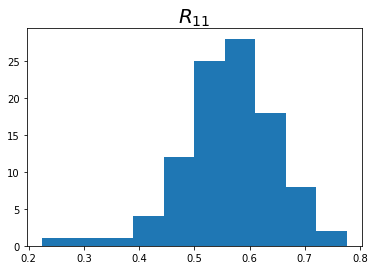

In [23]:
hist([R.numpy()[0,0] for R in R_list])
title('$R_{11}$',fontsize=20)
savefig('R_11_dist.png')

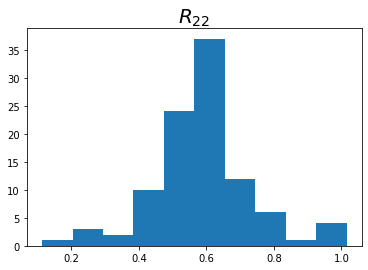

In [22]:
hist([R.numpy()[1,1] for R in R_list])
title('$R_{22}$',fontsize=20)
savefig('R_22_dist.png')